# Header

text

**Note:** text

In [5]:
import seisbench.data as sbd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
from config import load_config

In [6]:
import warnings
warnings.simplefilter('ignore', DeprecationWarning)

#### Loading configuration file

In [7]:
cfg = load_config('Kaki-cfg.yml')
print(cfg)

path: inp: /home/ekarkooti/Documents
catalog: /media/ekarkooti/ext4/Kahbasi-PhD/Kaki/Catalog-get-1403-06-10/kaki_all.out
stream: /media/ekarkooti/ext4/Kahbasi-PhD/Kaki/raw-gcf-data
network_details: /media/ekarkooti/ext4/Kahbasi-PhD/Kaki/Kaki_station-sensor-region-coords.csv
dataset: ./Kaki-Dataset-All_1403-06-12
model: path: ./model
name: PhaseNet_Kaki_1403-06





### Loading the dataset

Now that the dataset conversion is finished, we can check it by simply loading it. Here we load the dataset, print the metadata and visualize the first waveform together with the annotated pick.

In [8]:
base_path = Path(cfg.path.dataset)

data = sbd.WaveformDataset(base_path, sampling_rate=100)

2024-09-02 15:43:53,534 | seisbench | WARNING | Component order not specified, defaulting to 'ZNE'.


In [9]:
print("Training examples:", len(data.train()))
print("Development examples:", len(data.dev()))
print("Test examples:", len(data.test()))

Training examples: 287
Development examples: 0
Test examples: 0


In [10]:
targets = [key for key in data.metadata.keys() if 'arrival' in key]
data.metadata[targets]
# data.metadata.keys()

,trace_Pg_arrival_sample,trace_AML_arrival_sample,trace_Sg_arrival_sample
0,6000.0,7092.0,NaN
1,6000.0,6491.0,6428.0
2,6000.0,6559.0,6234.0
3,6000.0,6850.0,NaN
4,6000.0,6709.0,6298.0
...,...,...,...
282,6000.0,6559.0,6390.0
283,6000.0,6253.0,6200.0
284,6000.0,6288.0,6250.0
285,6000.0,NaN,6164.0


(3, 12001)


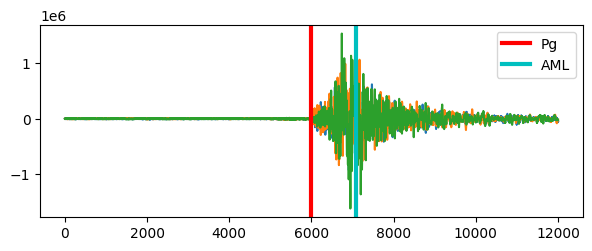

(3, 12001)


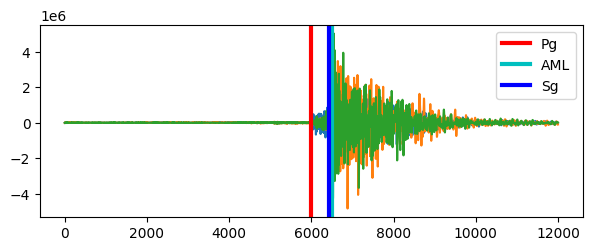

In [11]:
def cmap(phase_hint):
    c = {'Pg': 'r', 'Sg': 'b', 'AML': 'c'}
    return c.get(phase_hint, 'y')

for ii, metadata in data.metadata.iterrows():
    if ii == 2:
        break
    # print(metadata)
    fig = plt.figure(figsize=(7, 2.5))
    ax = fig.add_subplot(111)
    trace = data.get_waveforms(ii)
    print(trace.shape)
    ax.plot(trace.T)
    targets = [key for key in metadata.keys() if 'arrival' in key]
    targets = [key for key in targets if not np.isnan(metadata[key])]
    # print(targets, metadata[targets])
    for target in targets:
        phase_hint = target.split('_')[1]
        ax.axvline(metadata[target], lw=3, c=cmap(phase_hint), label=phase_hint)
    plt.legend()
    plt.show()

## Considerations for converting datasets

As outlined above, this tutorial provides a very minimal example on converting a dataset. Here we outline additional consideration that should be taken into account when preparing a dataset.

- **Grouping picks**: In this example, we created one trace for each pick. Naturally, traces will overlap if multiple picks, e.g., P and S phases, are available for an event at a station. For an example implementation of this grouping operation, have a look [here](https://github.com/seisbench/seisbench/blob/df94dcd86ce66d6a2ee2bd00da3857259fe579bd/seisbench/data/ethz.py#L109) and in the subsequent lines.
- **Adding station information**: In this example, we added no station information except its name. In practice, it will often be helpful for users to incorporate, for example, the location of the station. We skipped this step here, because it requires loading station inventories through FDSN. For an example implementation, have a look [here](https://github.com/seisbench/seisbench/blob/df94dcd86ce66d6a2ee2bd00da3857259fe579bd/seisbench/data/ethz.py#L315).
- **Memory requirements**: Internally, the `WaveformDataWriter` writes out the the waveforms continuously in blocks (see point below), but keeps all metadata in memory until the dataset is complete. For very large datasets (or very detailed metadata) this can result in several gigabytes of memory consumption. If you are writing such datasets, make sure the available memory on your machine is sufficient.
- **Waveform blocks**: Instead of writing each waveform separately, waveforms are written out in blocks. This massively improves IO performance. Have a look at [the documentation](https://seisbench.readthedocs.io/en/stable/pages/data_format.html#traces-blocks) for details on the strategy. We expect that in nearly all cases using the default setting will be a good choice.
- **FDSN considerations**: When converting very large datasets, the performance might be limited by the performance of the FDSN webservice. Unfortunately, downloading lots of short waveforms (as required for many machine learning applications) does not seem to be the most favorable use case for FDSN. This leads to rather slow performance when naively downloading the waveforms as outlined above. Instead, it is often helpful to issue [bulk requests](https://docs.obspy.org/master/packages/autogen/obspy.clients.fdsn.client.Client.get_waveforms_bulk.html). In addition, it might be a good choice to first download the waveforms and cache them locally, for example, in .mseed format, and then convert them to SeisBench.

For further details on the data format, check out [the data format specification in the SeisBench documentation](https://seisbench.readthedocs.io/en/stable/pages/data_format.html#traces-blocks).

(3, 12001)


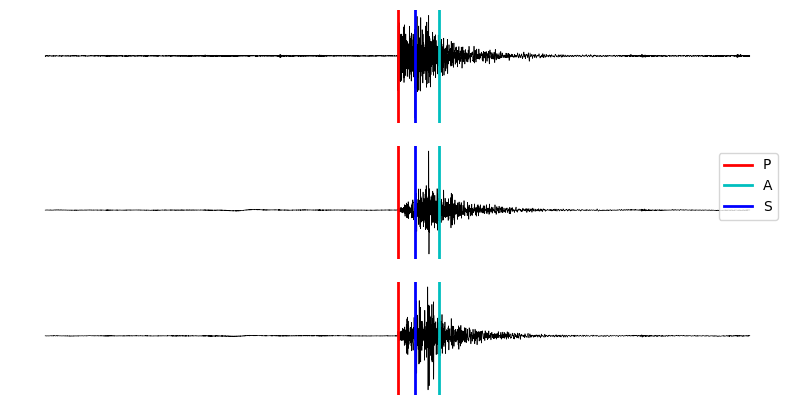

In [12]:
def cmap(phase_hint):
    c = {'Pg': 'r', 'Sg': 'b', 'AML': 'c'}
    return c.get(phase_hint, 'y')

ii = 4
metadata = data.metadata.iloc[ii]
# print(metadata)
fig, axes = plt.subplots(3, 1, figsize=(10, 5), sharex=True)
trace = data.get_waveforms(ii)
print(trace.shape)
for jj in range(3):
    axes[jj].plot(trace.T[:, jj], c='k', lw=0.5)
    axes[jj].patch.set_visible(False)
    axes[jj].axis('off')
targets = [key for key in metadata.keys() if 'arrival' in key]
targets = [key for key in targets if not np.isnan(metadata[key])]
# print(targets, metadata[targets])
for target in targets:
    phase_hint = target.split('_')[1]
    for jj in range(3):
        axes[jj].axvline(metadata[target], lw=2, c=cmap(phase_hint), label=phase_hint[0])
axes[1].legend()

In [13]:
metadata

index                                                                           4
source_id                          smi:local/690990bf-3b41-4d20-a11e-b7b7eb2d5d14
source_origin_time                                    2013-04-14T09:58:29.700000Z
source_origin_uncertainty_sec                                                 0.4
source_latitude_deg                                                        28.538
source_latitude_uncertainty_km                                           0.082738
source_longitude_deg                                                       51.636
source_longitude_uncertainty_km                                           0.08292
source_depth_km                                                               4.3
source_depth_uncertainty_km                                                 468.7
source_magnitude                                                              2.3
source_magnitude_uncertainty                                                  NaN
source_magnitude